# Navigable network
 In this project I will try to reproduce the research about finding a route or path between twitter users, useing decentralized algorithm.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import collections as col

import powerlaw as pw # pip intall powerlaw 

import random 
import seaborn as sn

import scipy
import math

# import dask.dataframe as dd

In [5]:
path_data = '../Data/'
path_pic = '../Pictures/'


# Preprocessed files:

* ...**sub files**, I selected a *smaller area* of the United States every node is part of this area. And because the navigability feature has no meaning in not fully connected networks, we work with the edgelist, nodelist and neighborlist of the **giant component**(GC) of the network.<br><br>

* ...**latlon file** contains every node's ID, with the latitude and longitude coordinates of the node with the transformed **x-y coordinates from lat-lon** (point column) So the euclidean distance works. $d = \sqrt{(\vec{x}-\vec{y})^2}$(https://epsg.io/26917)<br><br>
* ...**elist** big networks usually stored as edgelists, each row is an **edge of the network**, edge between a source and a target node. Our network is undirected so the direction or the order of source target nodes doesn't matter.<br><br>

* ...**neigh** : Created the **neighborlist of the network**, every node has neighbors (at least 1), those are stored in a **list**, the length of this list is the **degree**, and I added the **local clustering coefficient** of each node to the neighborlist.<br><br>


In [6]:
# I like long variable names. Sorry.
df_neigh_list_sub_GC_nodes = pd.read_excel(path_data+'neighbor_list_small_network_GC.xlsx') 
df_neigh_list_sub_GC_nodes['neighbors'] = df_neigh_list_sub_GC_nodes.neighbors.apply(lambda x: x[1:-1].split(','))
df_neigh_list_sub_GC_nodes['neighbors'] = df_neigh_list_sub_GC_nodes.neighbors.apply(lambda x: [int(xx) for xx in x])

df_latlon_sub_GC_nodes = pd.read_excel(path_data+'latlon_points_small_network_GC.xlsx')
df_latlon_sub_GC_nodes['point'] = df_latlon_sub_GC_nodes['point'].apply(lambda x: eval(x))

df_elist_sub_GC = pd.read_excel(path_data+'edgelist_small_network_GC.xlsx')


# A few networkscience features:
* size of network's GC
* degree distribution
* complementary cumulative degree distribution 
* degree distribution's exponent with powerlaw (https://pypi.org/project/powerlaw/ and https://nbviewer.jupyter.org/gist/anonymous/bb4e1dfafd9e90d5bc3d with examples)
* average clustering coefficient

In [7]:
def nr_of_nodes_from_elist(df_elist):
    return (df_elist['source'].append(df_elist['target'])).nunique()

def nr_of_edges_from_elist(df_elist):
    return len(df_elist)

def nr_of_edges_from_elist_parallel(df_elist):
    '''Every edge is parallel in df_elist'''
    return int(len(df_elist)/2)


def make_neigh_list(df_elist):
    neighs_of_source = dict(df_elist.groupby(by='source')['target'].apply(list))
    
    df_neigh = pd.DataFrame({'source':list(neighs_of_source.keys()),'neighbors':list(neighs_of_source.values())})
    df_neigh['degree'] = df_neigh['neighbors'].apply(len)
    return df_neigh

def degdist_from_network(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    degreeCount = col.Counter(degree_sequence)
    return dict(degreeCount.items())

def component_sizedist_from_network(G):
    connected_components = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
    conn_count = col.Counter(connected_components)
    return dict(conn_count.items())

def degdist_from_neigh_list(df_neigh):
    degree_sequence = sorted(list(df_neigh['degree']))
    degreeCount = col.Counter(degree_sequence)
    degreeCount = {k:(v/len(df_neigh)) for k,v in degreeCount.items()}
    return dict(degreeCount.items())

def cum_degdist_complementer_from_neigh_list(df_neigh):
    degdist = degdist_from_neigh_list(df_neigh)
    degdist = col.OrderedDict(sorted(degdist.items()))
    
    k_vals = list(degdist.keys())
    p_probs = list(degdist.values())
    
    cum_probs = []
    sub_list = []
    
    for i in range(len(k_vals)):
        sub_list.clear()
        sub_list = [x for x in p_probs[:i+1]]
        cum_probs.append(1-sum(sub_list))
    return dict(zip(k_vals,cum_probs))

def clustering_coeff_neigh_list(df_neigh,node_name):
    
    neighbors = df_neigh[df_neigh['source']==node_name]['neighbors'].iloc[0]
    k = len(neighbors)
    if k == 1:
        return 0.0
    
    links = 0.0
    
    sub_neighs = [set(x) for x in list(df_neigh[df_neigh.source.isin(neighbors)]['neighbors'])]
    neighbors = set(neighbors)
    for i in range(len(sub_neighs)):
        
        links += len(sub_neighs[i].intersection(neighbors))
    
    return links/(k*(k-1))

In [8]:
print('Nr. of nodes: ',nr_of_nodes_from_elist(df_elist_sub_GC))
print('Nr. of edges: ',nr_of_edges_from_elist(df_elist_sub_GC))


Nr. of nodes:  39501
Nr. of edges:  193299


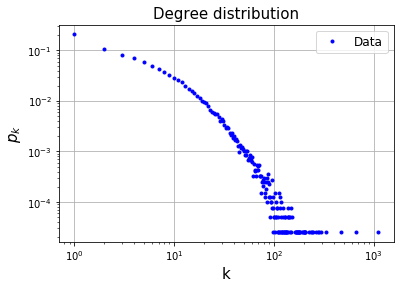

In [9]:
deg_dist_sub = degdist_from_neigh_list(df_neigh_list_sub_GC_nodes)

plt.plot(list(deg_dist_sub.keys()),list(deg_dist_sub.values()),'b.',label='Data')
plt.xscale('log')
plt.yscale('log')

plt.title('Degree distribution',fontsize=15)
plt.xlabel('k',fontsize=15)
plt.ylabel('$p_k$',fontsize=15)
plt.legend(fontsize=12)
plt.grid()
plt.savefig(path_pic+'degdist_small.png',dpi=200)

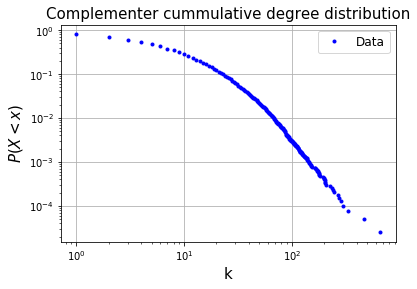

In [10]:
cum_deg_dist_sub = cum_degdist_complementer_from_neigh_list(df_neigh_list_sub_GC_nodes)

plt.plot(list(cum_deg_dist_sub.keys())[:-1],list(cum_deg_dist_sub.values())[:-1],'b.',label='Data')
plt.xscale('log')
plt.yscale('log')

plt.title('Complementer cummulative degree distribution',fontsize=15)
plt.xlabel('k',fontsize=15)
plt.ylabel('$P(X < x)$',fontsize=15)
plt.legend(fontsize=12)
plt.grid()
plt.savefig(path_pic+'cum_degdist_small.png',dpi=200)

In [ ]:
deg_dist_sub_squence = list(df_neigh_list_sub_GC_nodes.degree)
fit_deg = pw.Fit(deg_dist_sub_squence,discrete=True,xmin=10,xmax=999)


In [17]:
fit_deg.sigma

0.012427338101378771

In [21]:
print('Exponent of degree distribution: %.3f +/-' %fit_deg.alpha,'%.3f' %fit_deg.sigma)

Exponent of degree distribution: 2.374 +/- 0.012


In [22]:
clust_coef_avg = np.average(df_neigh_list_sub_GC_nodes.clus_coeff)
print('Avg. clustering coefficient: %.3f' %clust_coef_avg)

Avg. clustering coefficient: 0.172


# Distance distribution between every pairs

* Let's estimate the distance between a handful of users
* Let's calculate the distances between 5000 randomly choosen points.

In [11]:
N = len(df_neigh_list_sub_GC_nodes)
space = (((N*N-1)/2) * 8 ) * 1e-9
print('It\' difficult to calculate the distance between every node. It would require %.3f Gb memory' %space)

It' difficult to calculate the distance between every node. It would require 6.241 Gb memory


In [68]:
%%time
N_sample = 5000
points_coords = np.array([np.array([x[0],x[1]]) for x in df_latlon_sub_GC_nodes.sample(N_sample).point])
distances_betw_points = scipy.spatial.distance.cdist(points_coords,points_coords)

distances_betw_points = distances_betw_points[distances_betw_points != 0.0]
distances_betw_points = distances_betw_points.flatten() /1000


CPU times: user 568 ms, sys: 64 ms, total: 632 ms
Wall time: 463 ms


Text(0.5, 1.0, 'Distance between random users')

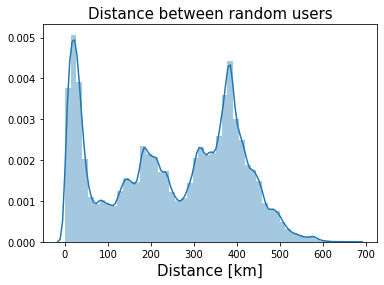

In [69]:
sn.distplot(distances_betw_points)
# plt.xscale('log')
plt.xlabel('Distance [km]',fontsize = 15)
plt.title('Distance between random users',fontsize = 15)
# plt.savefig(path_pic+'distance_dist_of_5000_points.png',dpi = 200)

# Conclusion:

* The sample is too big to run it myself, and the randomly choosen set doesn't follow a powerlaw.
* It's already a subset of the subset of the data. I don't expect similar results. The algorithms are similar to the original research.

# Greedy algorithm:

In [104]:
def get_distance(t1,t2):
    return math.sqrt((t1[0]-t2[0])**2 + (t1[1]-t2[1])**2)# it's in meters

def get_distance_from_node_names(n1,n2,df_latlon):
    t1 = df_latlon[df_latlon.user_id == n1].point.iloc[0]
    t2 = df_latlon[df_latlon.user_id == n2].point.iloc[0]
    return get_distance(t1,t2)

def get_closest_neigh_to_target_node(neighbors,target_node,df_latlon):
    target_coord = df_latlon[df_latlon.user_id == target_node].point.iloc[0]
    
    coordinates = [df_latlon[df_latlon.user_id == n].point.iloc[0] for n in neighbors]
    distances = [get_distance(t,target_coord) for t in coordinates]
    return neighbors[distances.index(min(distances))]

def get_closest_neigh_to_target_node_no_reps(neighbors,target_node,df_latlon,path_nodes):
    target_coord = df_latlon[df_latlon.user_id == target_node].point.iloc[0]
    
    coordinates = [df_latlon[df_latlon.user_id == n].point.iloc[0] for n in neighbors]
    distances = [get_distance(t,target_coord) for t in coordinates]
    distances = [x for x in distances if x not in path_nodes]
    
    return neighbors[distances.index(min(distances))]



def get_greedy_path(start_node,target_node,df_neigh,df_latlon,max_steps = 30):
    
    if start_node == target_node:
        return []
    
    nr_step = 0    
    current_node = start_node
    
    path_of_nodes = []
    path_of_nodes.append(start_node)
    
    while nr_step < max_steps and current_node != target_node:
        nr_step +=1 
        
        neighbors_of_curr = df_neigh[df_neigh.source == current_node].neighbors.iloc[0]
        neighbors_of_curr = list(set(neighbors_of_curr) - (set(path_of_nodes)))
        
        if neighbors_of_curr == []:
            return path_of_nodes
        
        current_node = get_closest_neigh_to_target_node(neighbors_of_curr,target_node,df_latlon)
        
        path_of_nodes.append(current_node)
    
    return path_of_nodes

def get_greedy_path_with_dist(start_node,target_node,df_neigh,df_latlon,max_steps = 30,dist_threshold=1000):
    
    if start_node == target_node:#don't deal with the same nodes
        return []
    
    nr_step = 0    
    current_node = start_node
    
    path_of_nodes = []
    path_of_nodes.append(start_node)
    
    while nr_step < max_steps and current_node != target_node:
        nr_step +=1 
        
        neighbors_of_curr = df_neigh[df_neigh.source == current_node].neighbors.iloc[0]#nearest neighbors
        neighbors_of_curr = list(set(neighbors_of_curr) - (set(path_of_nodes)))# don't hop on the same nodes again, infinite loops and stuff
        
        if neighbors_of_curr == []:#if run out of nodes: stop
            return path_of_nodes
        
        current_node = get_closest_neigh_to_target_node(neighbors_of_curr,target_node,df_latlon)
        
        path_of_nodes.append(current_node)
        
        #break loop, if we are close to the target
        dist_start_curr = get_distance_from_node_names(start_node,current_node,df_latlon)
        if dist_start_curr < dist_threshold: # less than x meters
            nr_step = max_steps
    
    return path_of_nodes


# Initialization:

In [121]:
nr_pairs = 2000
max_hop = 50
selected_nodes = random.sample(list(df_neigh_list_sub_GC_nodes.source), 2*nr_pairs)
starting_points = selected_nodes[:nr_pairs]
target_points = selected_nodes[nr_pairs:]

# 1 km threshold

In [127]:
%%time
print('Takes about 16 minutes.')
# with 1 km distance threshold
threshold_dist = 1000 #meters

paths_betw_points_with_dist = []
for i in range(nr_pairs):
    if i%100 == 0:
        print(i)
    paths_betw_points_with_dist.append(get_greedy_path_with_dist(starting_points[i],
                                                                 target_points[i],
                                                                 df_neigh_list_sub_GC_nodes,
                                                                 df_latlon_sub_GC_nodes,
                                                                 max_steps=max_hop,
                                                                 dist_threshold=threshold_dist))

Takes about 16 minutes.


In [124]:
df_greedy_results_dist = pd.DataFrame({'start':starting_points,'target':target_points,
                                  'path':paths_betw_points_with_dist})
df_greedy_results_dist['path_length'] = df_greedy_results_dist.path.apply(lambda x: len(x)) 

df_greedy_results_dist['distance_at_end'] = df_greedy_results_dist.apply(lambda x: get_distance_from_node_names(x.target,
                                                                                               x.path[-1],
                                                                                               df_latlon_sub_GC_nodes),axis=1)
df_greedy_results_dist['distance_at_start'] = df_greedy_results_dist.apply(lambda x: get_distance_from_node_names(x.target,
                                                                                               x.start,
                                                                                               df_latlon_sub_GC_nodes),axis=1)

df_greedy_results_dist['distance_at_end'] = df_greedy_results_dist['distance_at_end']/1000
df_greedy_results_dist['distance_at_start'] = df_greedy_results_dist['distance_at_start']/1000


In [128]:
# df_greedy_results_dist.to_excel(path_data+'greedy_results_distance_threshold_1000m_2000_pairs.xlsx',index=False)

# Repeat the routings on the same algorithm with 0.1 and 10 km threshold:

# 10 km

In [175]:
%%time
print('Takes about 10 minutes.')

# with 10 km distance threshold
nr_pairs = 2000
max_hop = 50
threshold_dist = 10000 #meters
selected_nodes = random.sample(list(df_neigh_list_sub_GC_nodes.source), 2*nr_pairs)
starting_points = selected_nodes[:nr_pairs]
target_points = selected_nodes[nr_pairs:]


paths_betw_points_with_dist_10000 = []
for i in range(nr_pairs):
    if i%100 == 0:
        print(i)
    paths_betw_points_with_dist_10000.append(get_greedy_path_with_dist(starting_points[i],
                                                                       target_points[i],
                                                                       df_neigh_list_sub_GC_nodes,
                                                                       df_latlon_sub_GC_nodes,
                                                                       max_steps=max_hop,
                                                                       dist_threshold=threshold_dist))

Takes about 16 minutes.
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
CPU times: user 10min 27s, sys: 212 ms, total: 10min 27s
Wall time: 10min 27s


In [176]:
df_greedy_results_dist_10000 = pd.DataFrame({'start':starting_points,'target':target_points,
                                  'path':paths_betw_points_with_dist_10000})
df_greedy_results_dist_10000['path_length'] = df_greedy_results_dist_10000.path.apply(lambda x: len(x)) 

df_greedy_results_dist_10000['distance_at_end'] = df_greedy_results_dist_10000.apply(lambda x: get_distance_from_node_names(x.target,
                                                                                               x.path[-1],
                                                                                               df_latlon_sub_GC_nodes),axis=1)
df_greedy_results_dist_10000['distance_at_start'] = df_greedy_results_dist_10000.apply(lambda x: get_distance_from_node_names(x.target,
                                                                                               x.start,
                                                                                               df_latlon_sub_GC_nodes),axis=1)

df_greedy_results_dist_10000['distance_at_end'] = df_greedy_results_dist_10000['distance_at_end']/1000
df_greedy_results_dist_10000['distance_at_start'] = df_greedy_results_dist_10000['distance_at_start']/1000


In [177]:
# df_greedy_results_dist_10000.to_excel(path_data+'greedy_results_distance_threshold_10000m_2000_pairs.xlsx',index=False)

# 0.1 km

In [178]:
%%time
print('Takes about 16 minutes.')

# with 10 km distance threshold
nr_pairs = 2000
max_hop = 50
threshold_dist = 100 #meters
selected_nodes = random.sample(list(df_neigh_list_sub_GC_nodes.source), 2*nr_pairs)
starting_points = selected_nodes[:nr_pairs]
target_points = selected_nodes[nr_pairs:]


paths_betw_points_with_dist_100 = []
for i in range(nr_pairs):
    if i%100 == 0:
        print(i)
    paths_betw_points_with_dist_100.append(get_greedy_path_with_dist(starting_points[i],
                                                                       target_points[i],
                                                                       df_neigh_list_sub_GC_nodes,
                                                                       df_latlon_sub_GC_nodes,
                                                                       max_steps=max_hop,
                                                                       dist_threshold=threshold_dist))

Takes about 16 minutes.
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
CPU times: user 15min 18s, sys: 43.9 ms, total: 15min 18s
Wall time: 15min 18s


In [179]:
df_greedy_results_dist_100 = pd.DataFrame({'start':starting_points,'target':target_points,
                                  'path':paths_betw_points_with_dist_100})
df_greedy_results_dist_100['path_length'] = df_greedy_results_dist_100.path.apply(lambda x: len(x)) 

df_greedy_results_dist_100['distance_at_end'] = df_greedy_results_dist_100.apply(lambda x: get_distance_from_node_names(x.target,
                                                                                               x.path[-1],
                                                                                               df_latlon_sub_GC_nodes),axis=1)
df_greedy_results_dist_100['distance_at_start'] = df_greedy_results_dist_100.apply(lambda x: get_distance_from_node_names(x.target,
                                                                                               x.start,
                                                                                               df_latlon_sub_GC_nodes),axis=1)

df_greedy_results_dist_100['distance_at_end'] = df_greedy_results_dist_100['distance_at_end']/1000
df_greedy_results_dist_100['distance_at_start'] = df_greedy_results_dist_100['distance_at_start']/1000


In [180]:
# df_greedy_results_dist_100.to_excel(path_data+'greedy_results_distance_threshold_100m_2000_pairs.xlsx',index=False)

# Results:
* The ratio of finished path
* Visualize one or two path on the map. 
* Distribution of required hop numbers
* Distribution of the distance between the targetnode and the starting node
* Distribution of the distance between the targetnode and the last path node


In [24]:
df_greedy_results_dist = pd.read_excel(path_data+'greedy_results_distance_threshold_1000m_2000_pairs.xlsx')
df_greedy_results_dist['path'] = df_greedy_results_dist.path.apply(lambda x: x[1:-1].split(','))
df_greedy_results_dist['path'] = df_greedy_results_dist.path.apply(lambda x: [int(xx) for xx in x])


df_greedy_results_dist_100 = pd.read_excel(path_data+'greedy_results_distance_threshold_100m_2000_pairs.xlsx')
df_greedy_results_dist_100['path'] = df_greedy_results_dist_100.path.apply(lambda x: x[1:-1].split(','))
df_greedy_results_dist_100['path'] = df_greedy_results_dist_100.path.apply(lambda x: [int(xx) for xx in x])

df_greedy_results_dist_10000 = pd.read_excel(path_data+'greedy_results_distance_threshold_10000m_2000_pairs.xlsx')
df_greedy_results_dist_10000['path'] = df_greedy_results_dist_10000.path.apply(lambda x: x[1:-1].split(','))
df_greedy_results_dist_10000['path'] = df_greedy_results_dist_10000.path.apply(lambda x: [int(xx) for xx in x])

In [25]:
df_greedy_results_dist_finished = df_greedy_results_dist[df_greedy_results_dist.path_length < 51]
df_greedy_results_dist_finished_10K = df_greedy_results_dist_10000[df_greedy_results_dist_10000.path_length < 51]
df_greedy_results_dist_finished_100 = df_greedy_results_dist_100[df_greedy_results_dist_100.path_length < 51]


In [26]:
def print_success(df_all,df_finished):
    print('The success ratio: ',len(df_finished)/len(df_all))
    print(len(df_finished),' successful routing out of ',len(df_all))

In [27]:
print('with 1 km threshold:')
print_success(df_greedy_results_dist,df_greedy_results_dist_finished)
print('with 10 km threshold:')
print_success(df_greedy_results_dist_10000,df_greedy_results_dist_finished_10K)
print('with 0.1 km threshold:')
print_success(df_greedy_results_dist_100,df_greedy_results_dist_finished_100)


with 1 km threshold:
The success ratio:  0.8605
1721  successful routing out of  2000
with 10 km threshold:
The success ratio:  0.9135
1827  successful routing out of  2000
with 0.1 km threshold:
The success ratio:  0.8535
1707  successful routing out of  2000


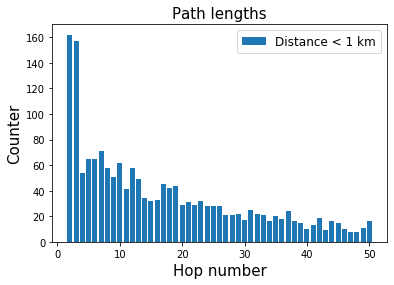

In [28]:
req_hop_nrs_1km = col.Counter(df_greedy_results_dist_finished.path_length)
plt.bar(list(req_hop_nrs_1km.keys()),height = list(req_hop_nrs_1km.values()),label='Distance < 1 km')
plt.xlabel('Hop number',fontsize = 15)
plt.ylabel('Counter',fontsize = 15)
plt.title('Path lengths',fontsize = 15)
plt.legend(fontsize = 12)
plt.savefig(path_pic+'success_plot_2000_pairs_dist_thresh_1000m.png',dpi = 200)

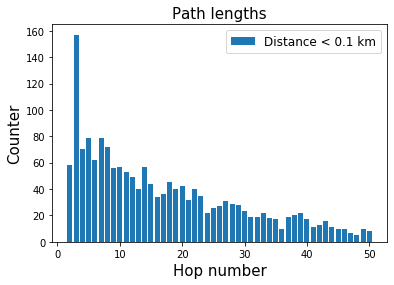

In [29]:
req_hop_nrs_100m = col.Counter(df_greedy_results_dist_finished_100.path_length)
plt.bar(list(req_hop_nrs_100m.keys()),height = list(req_hop_nrs_100m.values()),label='Distance < 0.1 km')
plt.xlabel('Hop number',fontsize = 15)
plt.ylabel('Counter',fontsize = 15)
plt.title('Path lengths',fontsize = 15)
plt.legend(fontsize = 12)
plt.savefig(path_pic+'success_plot_2000_pairs_dist_thresh_100m.png',dpi = 200)

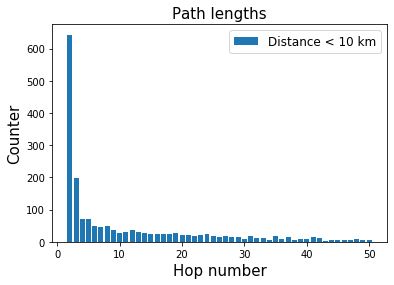

In [30]:
req_hop_nrs_10Km = col.Counter(df_greedy_results_dist_finished_10K.path_length)
plt.bar(list(req_hop_nrs_10Km.keys()),height = list(req_hop_nrs_10Km.values()),label='Distance < 10 km')
plt.xlabel('Hop number',fontsize = 15)
plt.ylabel('Counter',fontsize = 15)
plt.title('Path lengths',fontsize = 15)
plt.legend(fontsize = 12)
plt.savefig(path_pic+'success_plot_2000_pairs_thresh_10000m.png',dpi = 200)

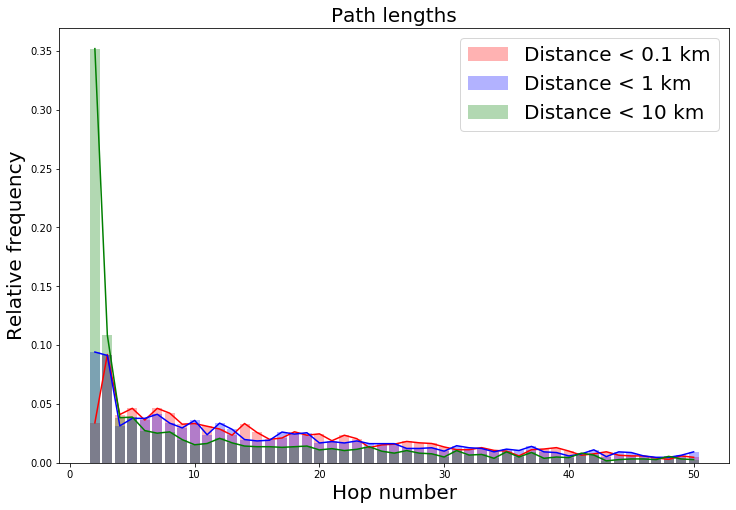

In [31]:
req_hop_nrs_100m = col.OrderedDict(sorted(col.Counter(df_greedy_results_dist_finished_100.path_length).items()))
req_hop_nrs_1km = col.OrderedDict(sorted(col.Counter(df_greedy_results_dist_finished.path_length).items()))
req_hop_nrs_10Km = col.OrderedDict(sorted(col.Counter(df_greedy_results_dist_finished_10K.path_length).items()))

req_hop_nrs_100m = {k:v/len(df_greedy_results_dist_finished_100) for k,v in req_hop_nrs_100m.items()}
req_hop_nrs_1km = {k:v/len(df_greedy_results_dist_finished) for k,v in req_hop_nrs_1km.items()}
req_hop_nrs_10Km = {k:v/len(df_greedy_results_dist_finished_10K) for k,v in req_hop_nrs_10Km.items()}


plt.figure(figsize=(12,8))
plt.bar(list(req_hop_nrs_100m.keys()),height = list(req_hop_nrs_100m.values()),color = 'red',alpha=0.3,label='Distance < 0.1 km')
plt.bar(list(req_hop_nrs_1km.keys()),height = list(req_hop_nrs_1km.values()),color = 'blue',alpha=0.3,label='Distance < 1 km')
plt.bar(list(req_hop_nrs_10Km.keys()),height = list(req_hop_nrs_10Km.values()),color = 'green',alpha=0.3,label='Distance < 10 km')


# plt.plot(list(req_hop_nrs_100m.keys()),list(req_hop_nrs_100m.values()),'_',ms=10,color = 'red')
# plt.plot(list(req_hop_nrs_1km.keys()),list(req_hop_nrs_1km.values()),'_',ms=10,color = 'blue')
# plt.plot(list(req_hop_nrs_10Km.keys()),list(req_hop_nrs_10Km.values()),'_',ms=10,color = 'green')

plt.plot(list(req_hop_nrs_100m.keys()),list(req_hop_nrs_100m.values()),'-',ms=10,color = 'red')
plt.plot(list(req_hop_nrs_1km.keys()),list(req_hop_nrs_1km.values()),'-',ms=10,color = 'blue')
plt.plot(list(req_hop_nrs_10Km.keys()),list(req_hop_nrs_10Km.values()),'-',ms=10,color = 'green')

plt.xlabel('Hop number',fontsize = 20)
plt.ylabel('Relative frequency',fontsize = 20)
plt.title('Path lengths',fontsize = 20)
plt.legend(fontsize = 20)
plt.savefig(path_pic+'hop_nr_dist_all_min_threshold_plot_2000_pairs.png',dpi = 200)

Text(0.5, 1.0, 'Distance between the target node and the end of path')

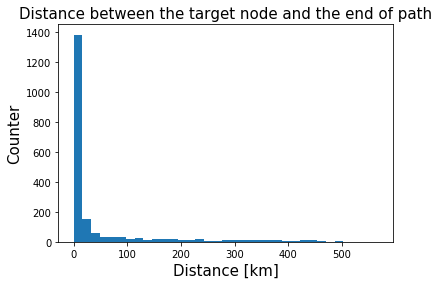

In [32]:
distances_end = list(df_greedy_results_dist.distance_at_end)
# sn.distplot(distances_end,bins=20,norm_hist=False)
plt.hist(distances_end,bins=35)
plt.xlabel('Distance [km]',fontsize = 15)
plt.ylabel('Counter',fontsize=15)
plt.title('Distance between the target node and the end of path',fontsize = 15)
# plt.savefig(path_pic+'distance_at_end_plot_2000_pairs.png',dpi = 200)

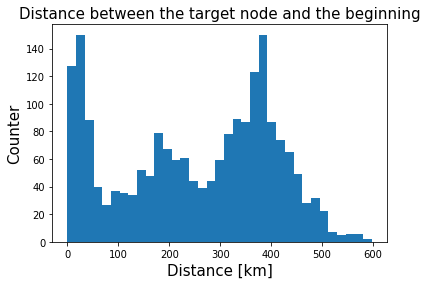

In [174]:
distances_start = list(df_greedy_results_dist.distance_at_start)
# sn.distplot(distances_start,bins=20,norm_hist=False)
plt.hist(distances_start,bins=35)
plt.ylabel('Counter',fontsize=15)
plt.xlabel('Distance [km]',fontsize = 15)
plt.title('Distance between the target node and the beginning',fontsize = 15)
# plt.savefig(path_pic+'distance_at_start_plot_2000_pairs.png',dpi = 200)

# Results and difficulties:
* The algorithm can find a path between the starting and target nodes in general. Or at lest reduce the distance between two users.
* But it has its own **limits**:


* Doesn't reach the target if the path length would be more than the **max hop number**
* **Infinity loops**, in these cases the algorithm breaks and returns with the last closest node
* Hop in a **dead end**.  If the closest neighbor to the target has only degree, there it has no more edges, so we can't get closer to the target, and we can't return the last node. 

# Without distance threshold:

In [109]:
# %%time 
# #without distance threshold
# paths_betw_points = []
# for i in range(nr_pairs):
#     if i%50 == 0:
#         print(i)
#     paths_betw_points.append(get_greedy_path(starting_points[i],
#                                              target_points[i],
#                                              df_neigh_list_sub_GC_nodes,
#                                              df_latlon_sub_GC_nodes,
#                                              max_steps=max_hop))

In [110]:
# df_greedy_results = pd.DataFrame({'start':starting_points,'target':target_points,
#                                   'path':paths_betw_points})
# df_greedy_results['path_length'] = df_greedy_results.path.apply(lambda x: len(x)) 

# df_greedy_results['distance_at_end'] = df_greedy_results.apply(lambda x: get_distance_from_node_names(x.target,
#                                                                                                x.path[-1],
#                                                                                                df_latlon_sub_GC_nodes),axis=1)
# df_greedy_results['distance_at_start'] = df_greedy_results.apply(lambda x: get_distance_from_node_names(x.target,
#                                                                                                x.start,
#                                                                                                df_latlon_sub_GC_nodes),axis=1)

# df_greedy_results['distance_at_end'] = df_greedy_results['distance_at_end']/1000
# df_greedy_results['distance_at_start'] = df_greedy_results['distance_at_start']/1000
